# ¡Hola, Héctor!  

Mi nombre es Carlos Ortiz, soy code reviewer de TripleTen y voy a revisar el proyecto que acabas de desarrollar.

Cuando vea un error la primera vez, lo señalaré. Deberás encontrarlo y arreglarlo. La intención es que te prepares para un espacio real de trabajo. En un trabajo, el líder de tu equipo hará lo mismo. Si no puedes solucionar el error, te daré más información en la próxima ocasión. 

Encontrarás mis comentarios más abajo - **por favor, no los muevas, no los modifiques ni los borres**.

¿Cómo lo voy a hacer? Voy a leer detenidamente cada una de las implementaciones que has llevado a cabo para cumplir con lo solicitado. Verás los comentarios de esta forma:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si todo está perfecto.
</div>


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>


<div class="alert alert-block alert-danger">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
    
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>


Puedes responderme de esta forma: 


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
</div>
¡Empecemos!

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

random_state=12345

warnings.simplefilter('ignore')

### Cargar datos

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Hola, Héctor. Nuestro código debe ejecutarse completamente para poder verificar los resultados obtenidos. Al parecer la ruta indicada no es la correcta. Continuaremos una vez esto sea corregido.
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
   <br> Quedó resulto.
</div>

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Preprocesamiento

In [4]:
data.sort_index(inplace=True)

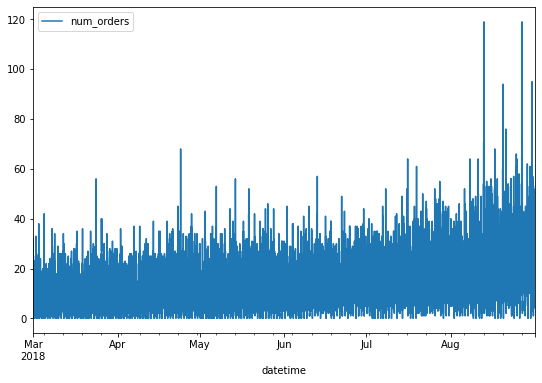

In [5]:
data.plot(figsize=(9,6))
plt.show()

Con la gráfica de arriba no podemos determinar con certeza si hay algun patrón sobre los pedidos de taxis, se analizará más a detalle.

## Análisis

Se hace un remuestreo de una hora para agrupar los datos tratando de obtener una vista más amigable.

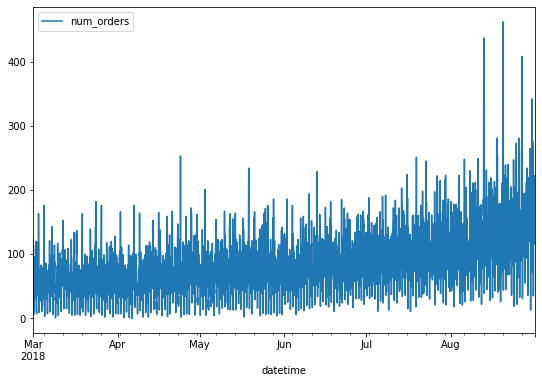

In [6]:
data_h = data.resample('1H').sum()
data_h.plot(figsize=(9,6))
plt.show()

Al no ver más claros tendencias en los datos se procederá a realizar la descomposición de estos para determinar tendencia, temporalidad y residuos

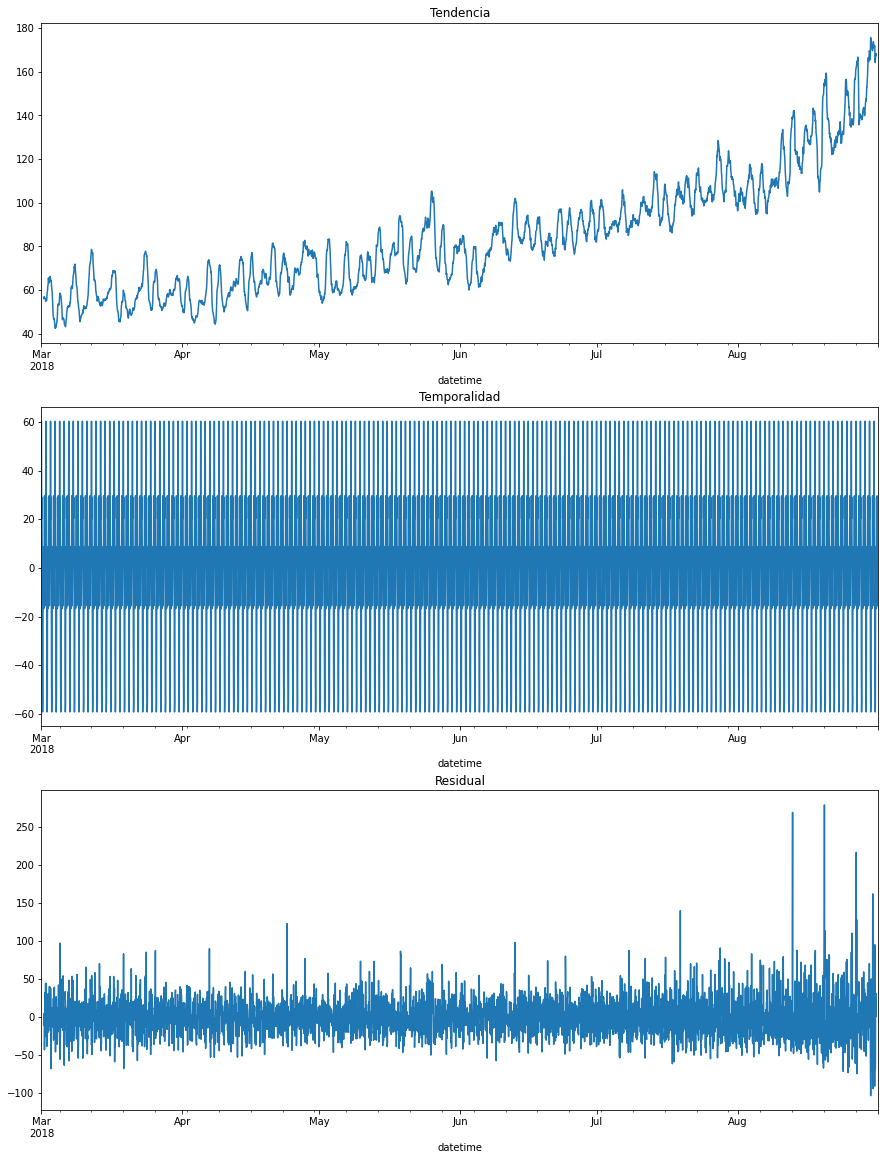

In [7]:
decomposed = seasonal_decompose(data_h)

plt.figure(figsize=(15,20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Temporalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.show()

Con los datos de esta forma nos damos cuenta que la tendencia va en aumento conforme avanza el año, en el verano incrementan los viajes al aeropuerto

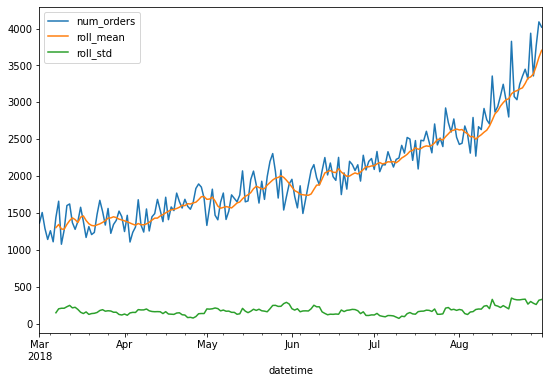

In [8]:
data_day = data_h.resample('1D').sum()
data_day['roll_mean'] = data_day['num_orders'].rolling(7).mean()

data_day['roll_std'] = data_day['num_orders'].rolling(7).std()

data_day.plot(figsize=(9,6))
plt.show()

Se tomará una semana de Mayo para revisar (Lunes a Domingo) 14 de mayo a 20 de mayo esto con el fin de encontrar alguna tendencia por día y realizar el análisis de mejor forma

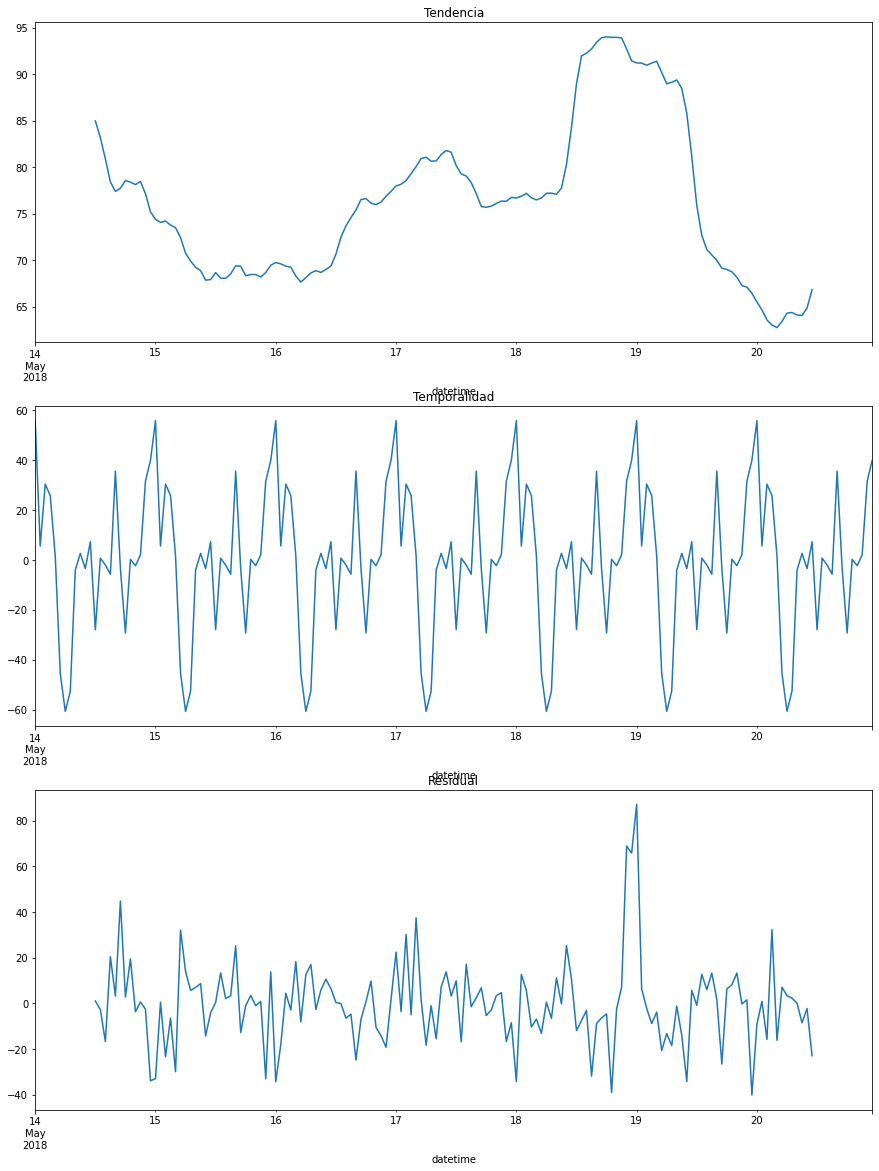

In [9]:
decomposed = seasonal_decompose(data_h.loc['2018-05-14':'2018-05-20', :])

plt.figure(figsize=(15,20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Temporalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.show()

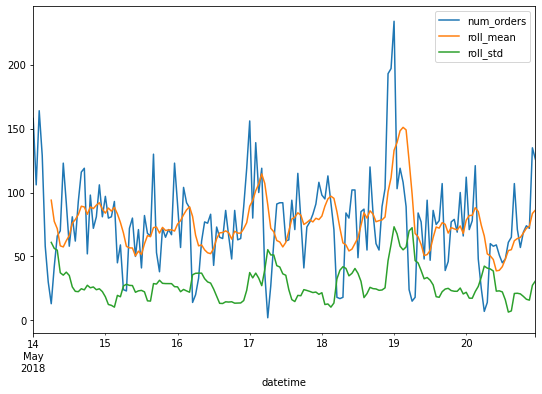

In [10]:
data_w = data_h.loc['2018-05-14':'2018-05-20', :]
data_w['roll_mean'] = data_w['num_orders'].rolling(7).mean()
data_w['roll_std'] = data_w['num_orders'].rolling(7).std()
data_w.plot(figsize=(9,6))
plt.show()

Con los gráficos de arriba podemos determinar que los sábados son los días con mayor pedidos de taxis, tomaremos el 19 de mayo como fecha para encontrar una tendencia por hora.

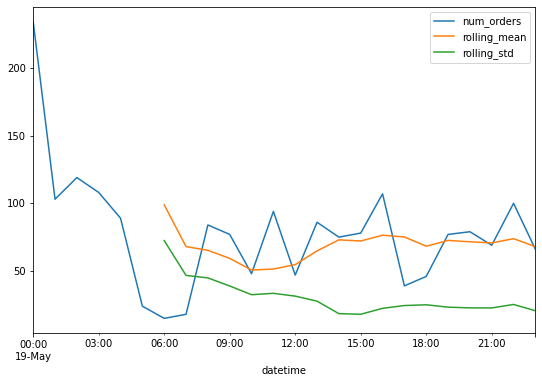

In [11]:
data_d = data_h.loc['2018-05-19', :].resample('1H').sum()
data_d['rolling_mean'] = data_d['num_orders'].rolling(7).mean()
data_d['rolling_std'] = data_d['num_orders'].rolling(7).std()
data_d.plot(figsize=(9,6))
plt.show()

A media noche es el punto con mayor cantidad de solicitudes de taxis

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Muy buen trabajo con este análisis gráfico.
</div>

## Formación

Se crean las caracteríscticas que nos ayudarán a usar modelos de predicción

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['roll_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_h, 7, 24)

In [13]:
data_h.dropna(inplace=True)
data_h.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,56.958333


Se crean los datasets de entrenamiento y prueba

In [14]:
train, test= train_test_split(data_h, shuffle=False, test_size=0.1)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Perfecto!
</div>

In [15]:
f_train = train.drop(['num_orders'],axis=1)
f_test = test.drop(['num_orders'],axis=1)
t_train = train['num_orders']
t_test = test['num_orders']

In [16]:
print(f_train.shape)
print(f_test.shape)

(3952, 12)
(440, 12)


Creamos un conjunto de entrenamiento y prueba utilizando la técnica `OHE`.

In [17]:
data_h_ohe = pd.get_dummies(data_h, columns=['month','day','dayofweek','hour'], drop_first=True)

f_ohe = data_h_ohe.drop(['num_orders'],axis=1)
t_ohe = data_h_ohe['num_orders']

f_ohe_train, f_ohe_test, t_ohe_train, t_ohe_test = train_test_split(f_ohe, t_ohe, shuffle=False, test_size=0.1)

print(f_ohe_train.shape)
print(f_ohe_test.shape)

(3952, 72)
(440, 72)


Se crea un `scorer` para encontrar los mejores parámetros

In [18]:
def recm(target, pred):
    mse = mean_squared_error(target, pred)**0.5
    return mse

scorer = make_scorer(recm, greater_is_better=False)

## Prueba

### Regresión lineal

In [19]:
lrm = LinearRegression()
lrm_score = cross_val_score(lrm, f_train, t_train, scoring=scorer, cv=5)
print(lrm_score.mean())

-30.457407988662123


Con este valor podemos entrenar nuestro modelo `Regresión lineal`

In [20]:
lr = LinearRegression()
lr.fit(f_train, t_train)
lr_pred = lr.predict(f_test)
lr_recm = recm(t_test, lr_pred)
print('RECM:',lr_recm)

RECM: 51.31242058840531


Ahora probaremos con los conjuntos de datos codificados

In [21]:
lr_ohe = LinearRegression()
lr_ohe.fit(f_ohe_train, t_ohe_train)
lr_ohe_pred = lr_ohe.predict(f_ohe_test)
lr_ohe_recm = recm(t_ohe_test, lr_ohe_pred)
print('RECM:',lr_ohe_recm)

RECM: 45.33827575859189


### Random Forest Regressor

In [22]:
for depth in range(1,11):
    rfr = RandomForestRegressor(n_estimators=45, max_depth=depth, random_state=random_state)
    rfr_score = cross_val_score(rfr, f_train, t_train, scoring=scorer, cv=5)
    print('Max_depth:', depth, 'score:', rfr_score.mean())

Max_depth: 1 score: -34.96368406683369
Max_depth: 2 score: -32.63729965262397
Max_depth: 3 score: -29.429730340160653
Max_depth: 4 score: -27.70176669674687
Max_depth: 5 score: -26.480279663467655
Max_depth: 6 score: -25.725398378577857
Max_depth: 7 score: -25.18538874383723
Max_depth: 8 score: -24.78484213261442
Max_depth: 9 score: -24.56979301798588
Max_depth: 10 score: -24.453098687141047


In [23]:
rfr = RandomForestRegressor(n_estimators=45, max_depth=10, random_state=random_state)
rfr.fit(f_train, t_train)
rfr_pred = rfr.predict(f_test)
rfr_recm = recm(t_test, rfr_pred)
print('RECM:',rfr_recm)

RECM: 45.44771506945086


### LGBM

Se buscarán los mejores parámetros del modelo LGBM para usarlos en nuestro modelo final y poder realizar la comparación con los otros dos modelos.

In [24]:
model = LGBMRegressor()

parameters = {
    'num_leaves': [10,20,30],
    'learning_rate':[0.1, 0.5],
    'n_estimators':[10,20],
    'random_state':[random_state]
}

grid = GridSearchCV(estimator=model, param_grid=parameters,scoring=scorer, cv=5)

grid.fit(f_train, t_train)

best_param = grid.best_params_
best_param

{'learning_rate': 0.5,
 'n_estimators': 10,
 'num_leaves': 30,
 'random_state': 12345}

In [25]:
lgbm = LGBMRegressor(learning_rate=0.5, n_estimators=10, num_leaves=30, random_state=random_state)
lgbm.fit(f_train, t_train)
lgbm_pred = lgbm.predict(f_test)
lgbm_recm = recm(t_test, lgbm_pred)
print('RECM:',lgbm_recm)

RECM: 44.412265827226854


Utilizando los data sets codificados

In [26]:
model = LGBMRegressor()

parameters = {
    'num_leaves': [10,20,30],
    'learning_rate':[0.1, 0.5],
    'n_estimators':[10,20],
    'random_state':[random_state]
}

grid = GridSearchCV(estimator=model, param_grid=parameters,scoring=scorer, cv=5)

grid.fit(f_ohe_train, t_ohe_train)

best_param = grid.best_params_
best_param

{'learning_rate': 0.5,
 'n_estimators': 20,
 'num_leaves': 10,
 'random_state': 12345}

In [27]:
lgbm_ohe = LGBMRegressor(learning_rate=0.5, n_estimators=10, num_leaves=30, random_state=random_state)
lgbm_ohe.fit(f_ohe_train, t_ohe_train)
lgbm_ohe_pred = lgbm_ohe.predict(f_ohe_test)
lgbm_ohe_recm = recm(t_ohe_test, lgbm_ohe_pred)
print('RECM:',lgbm_ohe_recm)

RECM: 46.94302811966527


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Excelente trabajo en esta sección!
</div>

## Resultados

In [28]:
results = pd.DataFrame(index=['LinearRegression','LinearRegression_OHE','RandomForestRegressor','LGBM','LGBM_OHE'],
                      data = {'RECM':[lr_recm, lr_ohe_recm, rfr_recm, lgbm_recm, lgbm_ohe_recm]})
results = results.sort_values(['RECM'], ascending=True)
results

,RECM
LGBM,44.412266
LinearRegression_OHE,45.338276
RandomForestRegressor,45.447715
LGBM_OHE,46.943028
LinearRegression,51.312421


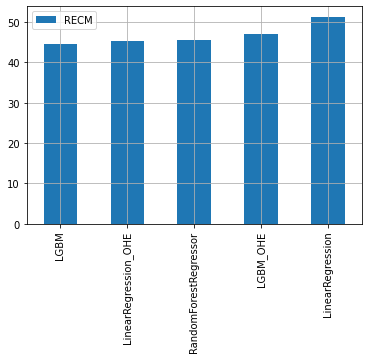

In [29]:
results.plot(kind='bar', grid=True)
plt.show()

De la gráfica podemos ver que el mejor modelo es el LGBM ya que tiene el menor valor de RECM que otros.

## Conclusiones

Las gráficas de tendencia que usamos a lo largo del proyecto fueron dificiles de analizar debido a la gran cantidad de datos que nos muestran, por otra parte al separar por una semana al azar del conjunto determinamos los días y horas donde hay más pedidos de taxis; es decir que de lo que encontramos en nuestro analisis los sábados a medianoche son los días que más pedidos podemos esperar.
Utilizando diferentes modelos de regresión, encontramos que el LGBM es el más certero en la predicción del número de pedidos de taxi a esperar por la compañía ya que obtuvo el valor más bajo de RECM de 44.41 estándo por debajo del obejetivo de 48.

<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Gran trabajo con el modelamiento! Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48